# Applying Subtopic Ratings
<p>ADD INFOMRATION HERE</p>


## Step 0: Import packages

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
from gensim.models.ldamulticore import LdaMulticore
import itertools
from collections import Counter

import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from math import ceil

import seaborn as sns
sns.set()

SUP_TITLE_FONT_SIZE = 25
TITLE_FONT_SIZE = 25
LABEL_FONT_SIZE = 15
TICK_FONT_SIZE  = 15

FIG_SIZE = (15,6)

DO_WRITE_CHARTS = True

def time_marker(text=''):
    print('[{}] {}'.format(datetime.datetime.now().time(), text))

## Step 1: Import Review Data with Subtopics

In [3]:
time_marker('Loading Restaurant Review data...')
reviews = pd.read_csv('../clean_data/az_restaurant_reviews_with_subtopics.csv', index_col=0, parse_dates=['date'], low_memory=False)

reviews.dropna(subset=['user_id'], inplace=True)

reviews.reset_index(inplace=True, drop=True)

reviews['chain_name'] = reviews['name'].str.lower().str.replace('[^\w\s]','').str.replace(' ', '_')

time_marker('done')

[02:01:02.437575] Loading Restaurant Review data...
[02:01:13.868231] done


In [4]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495893 entries, 0 to 495892
Data columns (total 22 columns):
business_id         495893 non-null object
cool                495893 non-null int64
date                495893 non-null datetime64[ns]
funny               495893 non-null int64
review_id           495893 non-null object
stars               495893 non-null int64
text                495893 non-null object
useful              495893 non-null int64
user_id             495893 non-null object
is_fast_food        495893 non-null bool
review_len          495893 non-null int64
name                495893 non-null object
atmosphere          94385 non-null float64
value               159932 non-null float64
retention           225063 non-null float64
cleanliness         1795 non-null float64
ordering            36124 non-null float64
customer_service    285977 non-null float64
wait_time           89636 non-null float64
menu_options        12243 non-null float64
food_quality        299715

## Step 2: Calculate Subtopic Ratings for Each Business
<p>Yelp Review Star Rounding is performed by rounding up to the nearest half star, the same way Yelp rounds off Business Star Ratings</p>

In [5]:
def yelp_star_rounding(stars):
    ''' 
        Yelp review stars are calculated by rounding the 
        average review scroe up to the nearest 0.5 so here 
        we use the same method for subtopic review stars.
    '''
    
    if stars > 0:
        result = ceil(stars*4)/4
    else:
        result = np.nan
    
    return result

In [6]:
# group reviews by business id
business_subtopic_ratings = reviews.groupby('business_id').mean()[reviews.columns[-10:-1]]

# apply yelp rounding to all ratings
# business_subtopic_ratings = business_subtopic_ratings.applymap(yelp_star_rounding)

business_subtopic_ratings.head(10)

,atmosphere,value,retention,cleanliness,ordering,customer_service,wait_time,menu_options,food_quality
business_id,,,,,,,,,
-050d_XIor1NpCuWkbIVaQ,4.133333,3.889908,4.118497,1.5,3.652174,4.177249,3.939577,2.857143,3.843750
-092wE7j5HZOogMLAh40zA,4.277778,3.272727,3.760000,NaN,3.250000,3.511628,3.000000,4.000000,3.051724
-0Sgh0QlUKVsWosCWJzGqQ,4.333333,1.800000,2.176471,NaN,1.448276,2.272727,1.380952,1.000000,2.050000
-0WegMt6Cy966qlDKhu6jA,2.681818,2.320000,2.433333,NaN,1.333333,2.485714,1.794118,1.000000,2.115385
-17CAGmIRBHpPFlWBTDGuw,NaN,5.000000,1.000000,NaN,5.000000,1.000000,NaN,NaN,2.333333
-1VaIJza42Hjev6ukacCNg,4.347826,4.000000,4.000000,NaN,3.000000,4.066667,3.277778,NaN,3.518519
-2A9emZwBK8zYHPnAmM0hw,NaN,3.000000,3.333333,NaN,1.000000,3.400000,2.000000,NaN,2.166667
-2isRNVb6PDuBagELL5EBw,2.000000,4.000000,3.600000,NaN,2.250000,3.666667,3.000000,NaN,3.100000
-34vSRcMz_RjN00dWIiQ3Q,3.000000,2.333333,2.857143,NaN,NaN,3.125000,1.500000,NaN,2.714286


In [7]:
business_subtopic_ratings.describe()

,atmosphere,value,retention,cleanliness,ordering,customer_service,wait_time,menu_options,food_quality
count,5814.000000,6689.000000,6841.000000,1326.000000,5442.000000,6959.000000,6248.000000,3353.000000,7024.000000
mean,3.926962,3.256184,3.343873,2.833606,2.563436,3.511395,2.918466,3.531219,3.084629
std,0.969922,0.912155,0.985701,1.559800,1.146207,0.925220,1.081782,1.261665,0.865640
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,3.571429,2.800000,2.750000,1.000000,1.600000,3.000000,2.047619,3.000000,2.500000
50%,4.166667,3.400000,3.545455,3.000000,2.500000,3.679739,3.000000,4.000000,3.166667
75%,4.564538,3.888889,4.040404,4.000000,3.333333,4.191675,3.740159,4.500000,3.714286
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


## Step 3: Import Restaurant Business Data
<p>Merge Subtopic Ratings to business information DataFrame</p>

In [8]:
time_marker('Loading Restaurant Business data...')
biz_data = pd.read_csv('../clean_data/az_restaurant_business_clean.csv', index_col=0)
biz_data = biz_data.iloc[:,:10].copy()

biz_data['chain_name'] = biz_data['name'].str.lower().str.replace('[^\w\s]','').str.replace(' ', '_')


[02:01:14.955672] Loading Restaurant Business data...


In [9]:
# Merge Subtopic Ratings
biz_subtopics = biz_data.merge(business_subtopic_ratings, left_on='business_id', right_index=True)

In [10]:
biz_subtopics.head(3).transpose()

,0,1,2
address,777 E Thunderbird Rd Ste 107,10720 E Southern Ave,8140 N Hayden Rd Ste H115
business_id,1WBkAuQg81kokZIPMpn9Zg,kKx8iCJkomVQBdWHnmmOiA,VdlPZg2NAu8t8GkdbPLecg
categories,"['burgers', 'restaurants']","['restaurants', 'pizza']","['restaurants', 'gluten-free', 'indian', 'seaf..."
city,Phoenix,Mesa,Scottsdale
is_open,1,1,1
name,Charr An American Burger Bar,Little Caesars Pizza,Tandoori Times Indian Bistro
postal_code,85022,85209,85258
review_count,232,4,263
stars,3,2.5,3.5
is_fast_food,0,0,0


## Step 4: Plotting Subtopic Review Stars against Restaurant Star Ratings
<p>Restarants are givena single Star Rating, these ratings are compared to our calculated Rating for each of the 9 identified Sub Topics.  Using a set of box plots, we can see that Four possible trends appear.</p>


In [11]:
def plot_suptopic_comparisons(df, palette='Reds_r', title_prefix=''):
    
    nrows = 3
    ncols = 3
    size = 6

    subtopic_labels = list(df.columns[-9:])

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*size, nrows*size))

    for rr, row in enumerate(ax):
        for cc, col in enumerate(row):
            subtopic_label = subtopic_labels[rr*ncols + cc]

            ax = plt.subplot(nrows, ncols, rr*ncols + cc+1)
            ax = sns.boxplot(x="stars", y=df[subtopic_label], data=df, palette=palette)
            
            
            ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

            ax.set_xlabel('Restaurant Star Rating', size=LABEL_FONT_SIZE)
            ax.set_ylabel('{} Rating'.format(subtopic_label).replace('_', ' ').title(), weight='bold',  size=LABEL_FONT_SIZE)
            
            ax.set_yticks([x/4 for x in range(4, 21)])
            

    plt.suptitle('{} Subtopic Rating Review'.format(title_prefix.title().title()), size=25, weight='bold', y=0.90)
    
    if DO_WRITE_CHARTS:
        plt.savefig('../charts/reports/subtopic_review_{}.png'.format(title_prefix.replace(' ', '_').lower()))
    plt.show()
    plt.close()

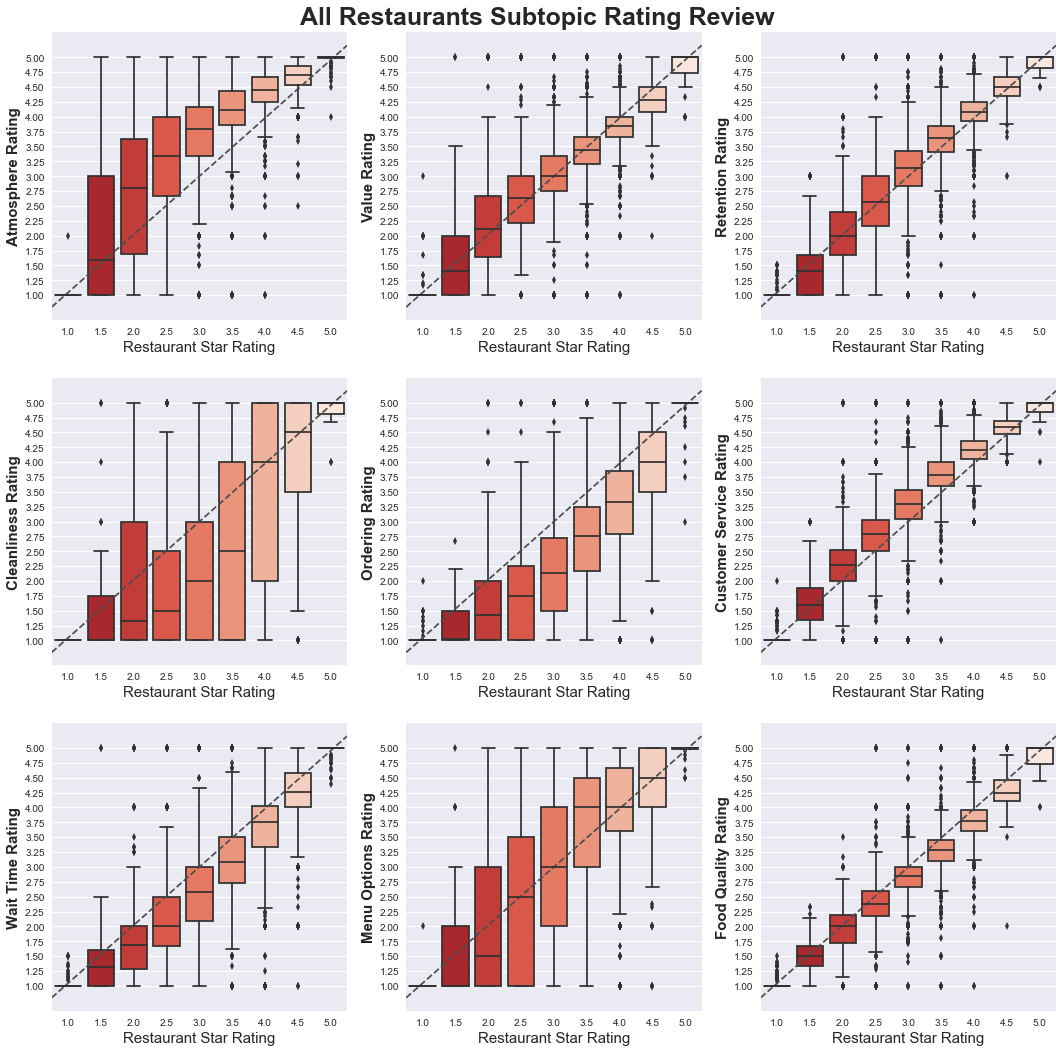

In [12]:
plot_suptopic_comparisons(biz_subtopics, palette='Reds_r', title_prefix='All Restaurants')

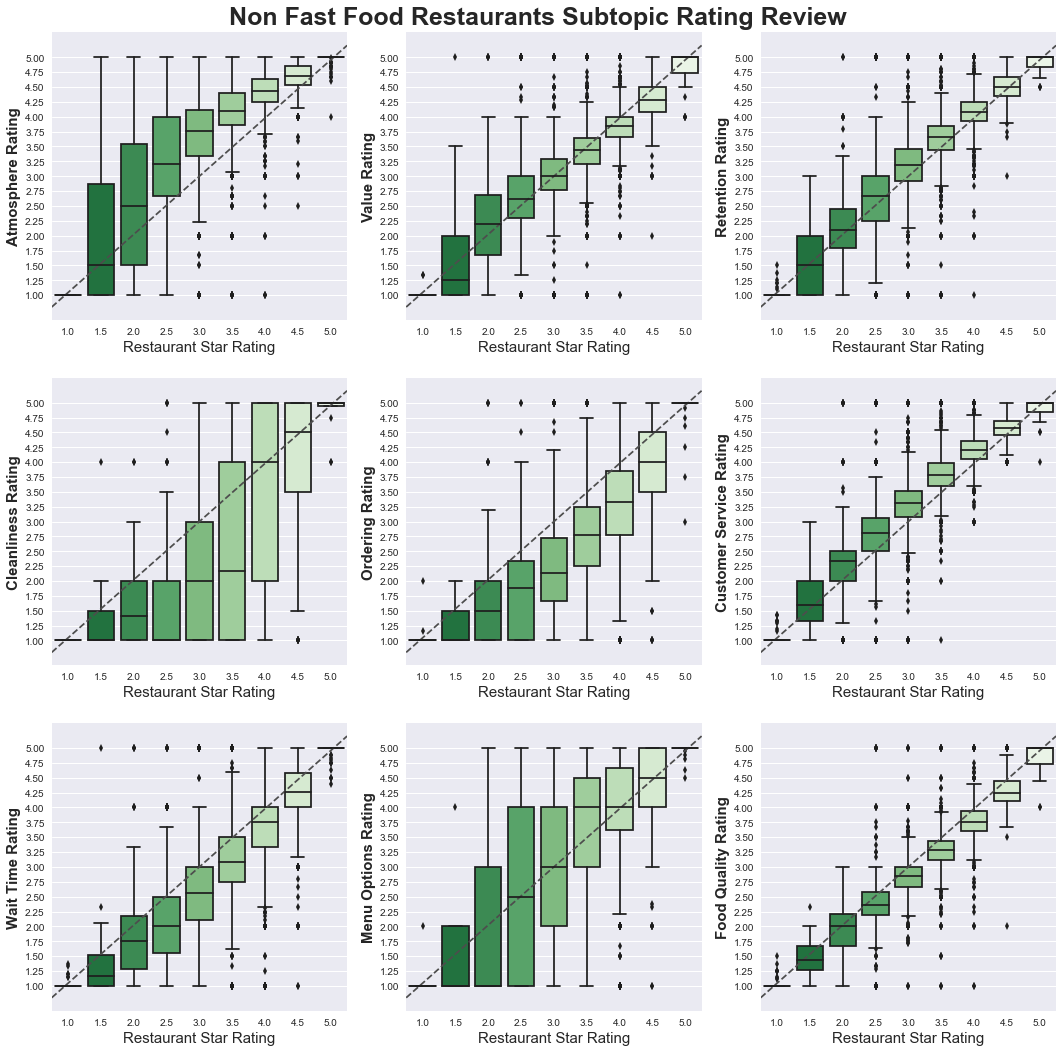

In [13]:
plot_suptopic_comparisons(biz_subtopics[biz_subtopics.is_fast_food == 0], palette='Greens_r', 
                          title_prefix='Non Fast Food Restaurants')

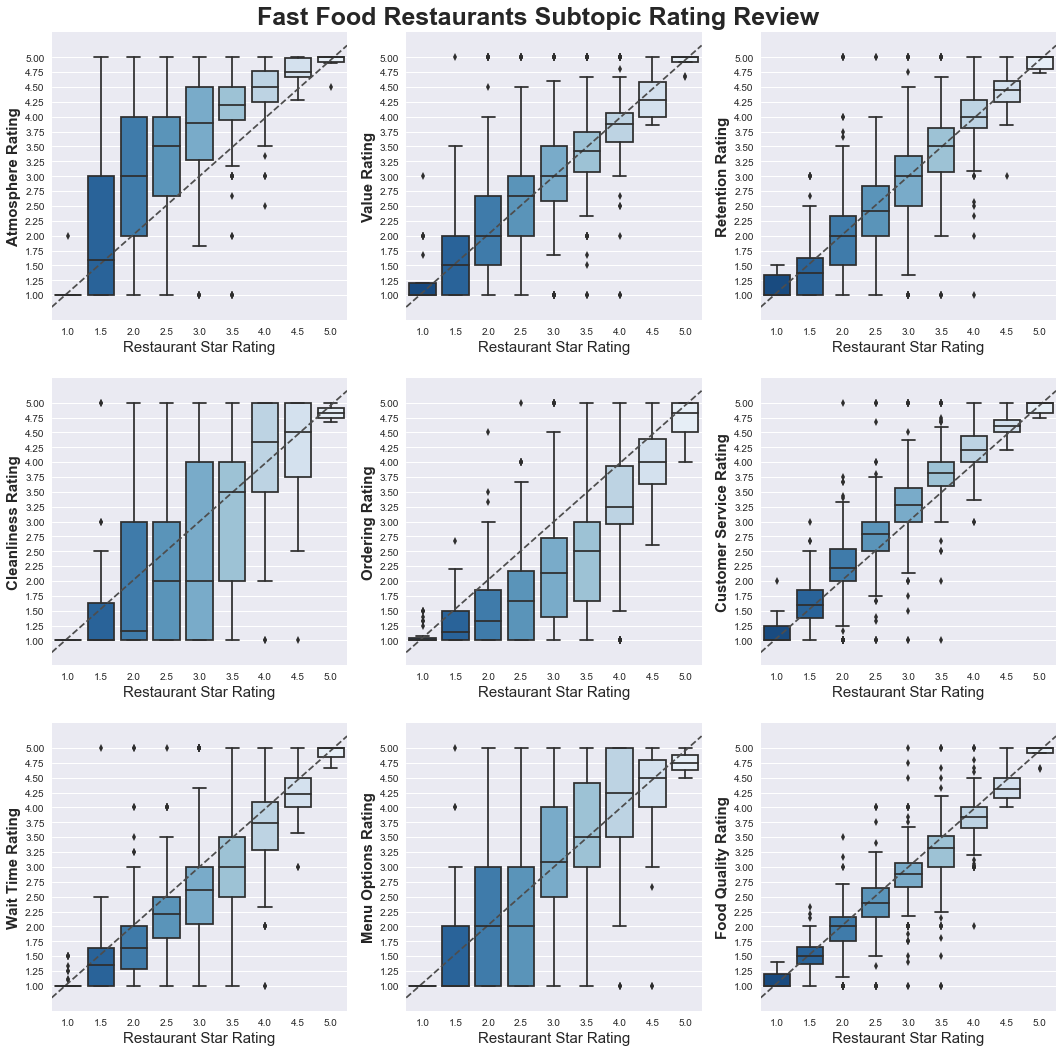

In [14]:
plot_suptopic_comparisons(biz_subtopics[biz_subtopics.is_fast_food == 1], palette='Blues_r',
                          title_prefix='Fast Food Restaurants')

## Step 5:  Compare Restaurant to Others in the same Chain
<p>Given a `business_id` this report shows the status of the given business in comparison to others bearing the same name.</p>

In [15]:
biz_data.head(3)

,address,business_id,categories,city,is_open,name,postal_code,review_count,stars,is_fast_food,chain_name
0,777 E Thunderbird Rd Ste 107,1WBkAuQg81kokZIPMpn9Zg,"['burgers', 'restaurants']",Phoenix,1,Charr An American Burger Bar,85022.0,232,3.0,0,charr_an_american_burger_bar
1,10720 E Southern Ave,kKx8iCJkomVQBdWHnmmOiA,"['restaurants', 'pizza']",Mesa,1,Little Caesars Pizza,85209.0,4,2.5,0,little_caesars_pizza
2,8140 N Hayden Rd Ste H115,VdlPZg2NAu8t8GkdbPLecg,"['restaurants', 'gluten-free', 'indian', 'seaf...",Scottsdale,1,Tandoori Times Indian Bistro,85258.0,263,3.5,0,tandoori_times_indian_bistro


### Collect Information on specific Business

In [16]:
def get_business_information(df, business_id):
    ''' Get dict of business attributes from a given business_id '''
    business_information = df[df.business_id == business_id].transpose().to_dict()
    results = list(business_information.values())[0]
    
    # convert categories from string to list
    results['categories'] = results['categories'].split("'")[1::2]
    
    return results

### Plot Business Rankings in Comparison to all Others in the Chain
<ul> Parameters
    <li><b>df</b>: the DataFrame of reviews to draw from</li>
    <li><b>bid</b>: the business_id of the business in question, this location is shown as a blue line in each Sub Rating</li>
    <li><b>min_reviews</b>: The minumum number of reviews for another business in the chain to be included</li>
    <li><b>min_biz</b>: The minumum number of other businesses in the chain.</li>
</ul>

In [17]:
def compare_to_chain(df, bid, min_reviews=10, min_biz=5):
    '''
        when passed a dataframe of reviews, collect ratings from all other businesses with the same name.
        Plot in red dots, the reviews in each Sub Category for each location.
    '''

    business_information = get_business_information(biz_subtopics, bid)
    business_address = '{} {} AZ'.format(business_information['address'], business_information['city'])
    if df[df.business_id == bid].shape[0] < min_reviews:
        print('Skipping {} at {}, not enough reviews at this location {:d}'.format(business_information['name'], business_address,  df[df.business_id == bid].shape[0]))
        return False
   
    # all locations with the same name
    chain_reviews = df[df.name == business_information['name']].copy()
    chain_reviews = chain_reviews.groupby('business_id').mean()
    
    # only generate report if the number of other locations is greater than min_biz 
    if chain_reviews.shape[0] < min_biz:
        print('Skipping {}, not enough other businesses {:d}'.format(business_information['name'], chain_reviews.shape[0]))
        return False
    
    # get count of reviews from each location
    review_countss = df[df.name == business_information['name']].groupby('business_id').count()['name'].to_frame()

    # select only businesses with more than min_reviews reviews
    location_review_counts = review_countss[review_countss.name > min_reviews].copy()

    # subset chain reviews to include only those with more than min_reviews reviews
    chain_reviews = chain_reviews[chain_reviews.index.isin(location_review_counts.index)].copy()

    
    # Plotting!
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
    
    
    ax1 = plt.subplot(1, 10, (1,9))
    
    # plot the specific bid with lines
    sample_location_ratings = chain_reviews[chain_reviews.index == bid].mean()[-9:].values
        
    for ii, val in enumerate(sample_location_ratings):
        ax1.axhline(val, xmin=ii/9+0.005, xmax=(ii+1)/9-0.005, color='r', linewidth=5)


    # melt data frame for seaborn boxplot
    chain_melt = chain_reviews[chain_reviews.index != bid].iloc[:,-9:].melt()


    # strip plot of subtopic reviews
    sns.stripplot(x='variable', y='value', data=chain_melt, 
                  color='k', size=10, alpha=.2, 
                  jitter=True, edgecolor='none', ax=ax1)

    
    # formatting title and axis
    plt.suptitle('{} at {}'.format(business_information['name'], business_address), size=SUP_TITLE_FONT_SIZE, weight='bold', y=0.95)
    ax1.set_title('Compared to all other {} Restaurants'.format(business_information['name']), size=LABEL_FONT_SIZE)

    ax1.set_ylabel('Rating', size=LABEL_FONT_SIZE)
    ax1.set_xlabel('')
    ax1.set_xticklabels([x.replace('_', ' ').title() for x in biz_subtopics.columns[-9:]], size=12)
    ax1.set_yticks([(x/2)+1 for x in range(0, 9)])
    
    
    # draw faint lines to deliniate Sub Ratings
    for y in range(1, 9):
        ax1.axvline(y-0.5, linestyle='-', alpha=1, color='w')
    
    
    # plot overall review scores
    ax2 = plt.subplot(1, 10, 10)
    ax2.axhline(business_information['stars'], color='r', linewidth=5)
    
    chain_stars = chain_reviews.groupby('business_id').mean()['stars'].to_frame().melt()
    sns.stripplot(x='variable', y='value', data=chain_stars, 
                  color='k', size=10, alpha=.2, 
                  jitter=True, edgecolor='none', ax=ax2)
    
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.set_ylim(0.75,5.25)
    ax2.set_yticklabels([])
    ax2.set_xticklabels(['Yelp Stars'], size=12, weight='bold')
    
    file_path = '../charts/reports/chain/{}_{}_chain_comparison.png'.format(business_information['chain_name'].replace('_',''), bid)    
    if DO_WRITE_CHARTS:
        plt.savefig(file_path)
  
    plt.show()
    plt.close()
    
    return file_path

### Identify Chains with most Locations

In [18]:
def get_top_n_chains(n, ff=''):

    if ff == 'ff':
        top_n_chains = [x[0] for x in Counter(biz_data[biz_data.is_fast_food == 1].chain_name).most_common(n)]
    elif ff == 'nff':
        top_n_chains = [x[0] for x in Counter(biz_data[biz_data.is_fast_food == 0].chain_name).most_common(n)]
    else:
        top_n_chains = [x[0] for x in Counter(biz_data.chain_name).most_common(n)]
        
    # etract business_id values of all retaurants in top_ten_chains
    top_n_chain_bids = list(reviews[reviews.chain_name.isin(top_n_chains)].business_id.unique())


    print('Working with reviews for {:d} Restaurants across {:d} Chains'.format(len(top_n_chain_bids), n))
    
    return top_n_chain_bids


In [19]:
all_chain_bids = get_top_n_chains(5)

Working with reviews for 696 Restaurants across 5 Chains


In [20]:
ff_chain_bids = get_top_n_chains(5, ff='ff')

Working with reviews for 696 Restaurants across 5 Chains


In [21]:
nff_chain_bids = get_top_n_chains(5, ff='nff')

Working with reviews for 258 Restaurants across 5 Chains


# UNCOMMENT THIS TO RUN ALL CHARTS

In [22]:
# [compare_to_chain(reviews, x) for x in nff_chain_bids]

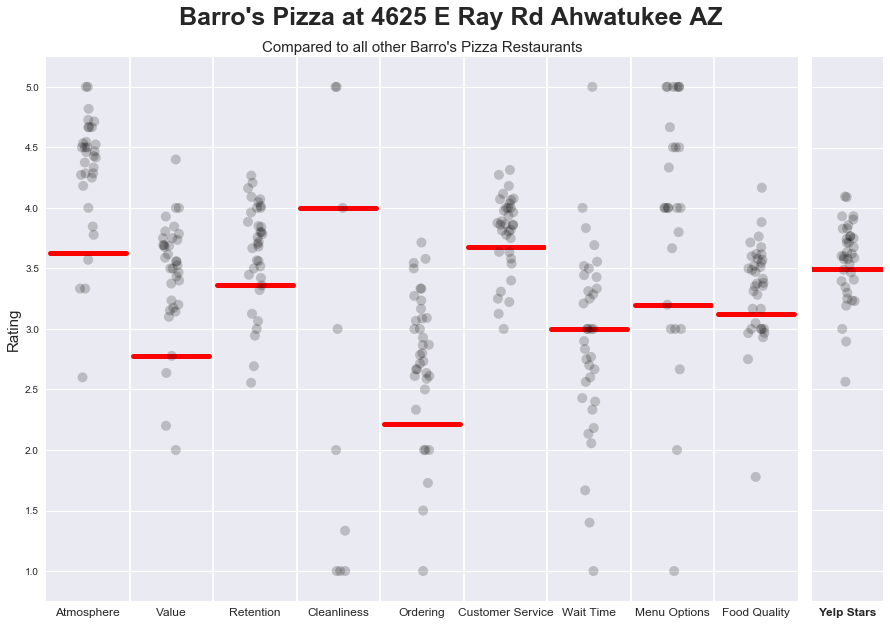

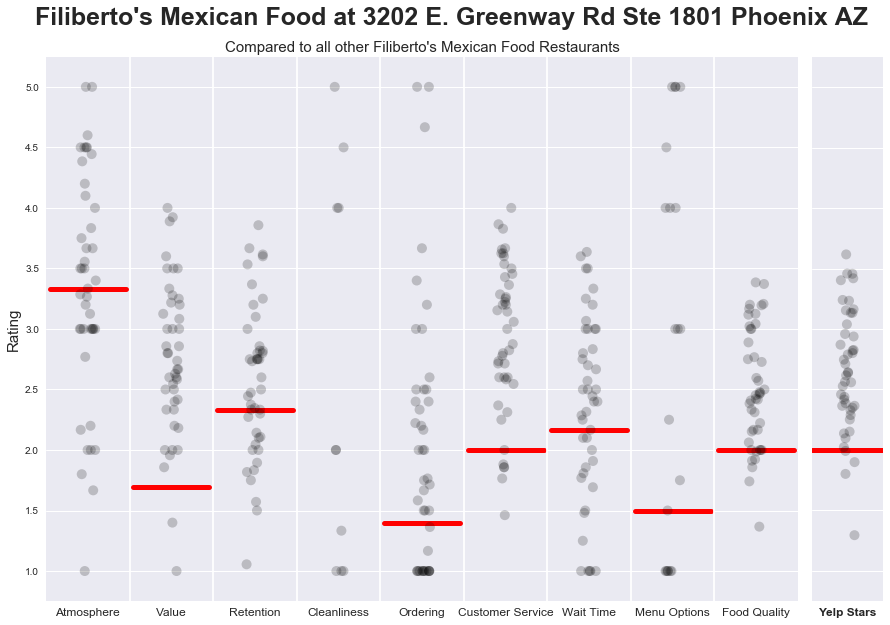

['../charts/reports/chain/barrospizza_0Rni7ocMC_Lg2UH0lDeKMQ_chain_comparison.png',
 '../charts/reports/chain/filibertosmexicanfood_mcXRNuN1MsgXYt8B2MWz2Q_chain_comparison.png']

In [23]:
# display a subset for reference
[compare_to_chain(reviews, x) for x in nff_chain_bids[:2]]